<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget - nc https://lazyprogrammer.me/course_files/SPY.csv

--2023-11-25 04:12:21--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2023-11-25 04:12:21--  http://nc/
Resolving nc (nc)... failed: No address associated with hostname.
wget: unable to resolve host address ‘nc’
--2023-11-25 04:12:21--  https://lazyprogrammer.me/course_files/SPY.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251935 (246K) [text/csv]
Saving to: ‘SPY.csv’

SPY.csv             100%[===================>] 246.03K  --.-KB/s    in 0.006s  

2023-11-25 04:12:21 (38.0 MB/s) - ‘SPY.csv’ saved [251935/251935]

FINISHED --2023-11-25 04:12:21--
Total wall clock time: 0.4s
Downloaded: 1 files, 246K in 0.006s (38.0 MB/s)


In [2]:
!pip install -U arch statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 12.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [4]:
df = pd.read_csv("SPY.csv",index_col = 'Date',parse_dates = True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [6]:
df['LogRet'] = np.log(df['Close']).diff()

In [7]:
#Because the first row do not contain any return value
df2 = df.iloc[1:].copy()

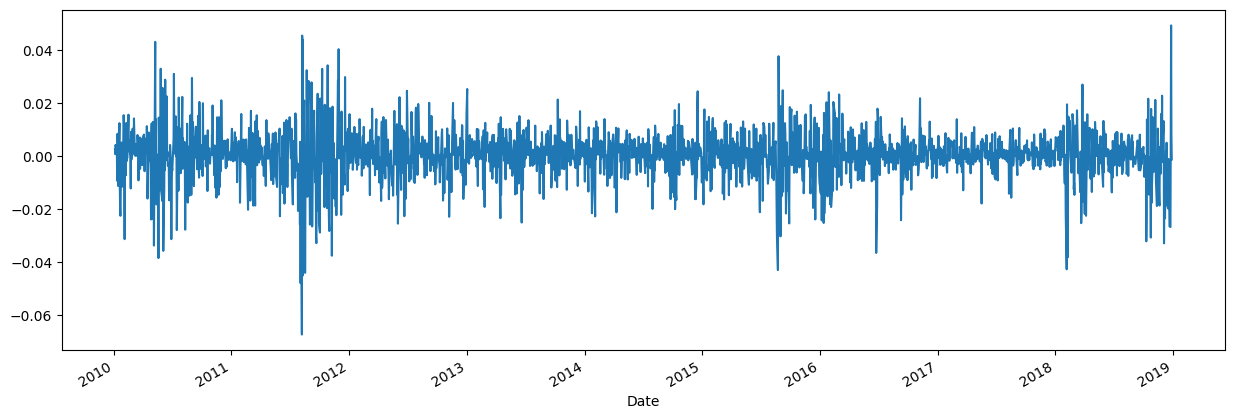

In [8]:
df2['LogRet'].plot(figsize = (15,5));

In [9]:
df2['Ysq'] = df2['LogRet'] ** 2

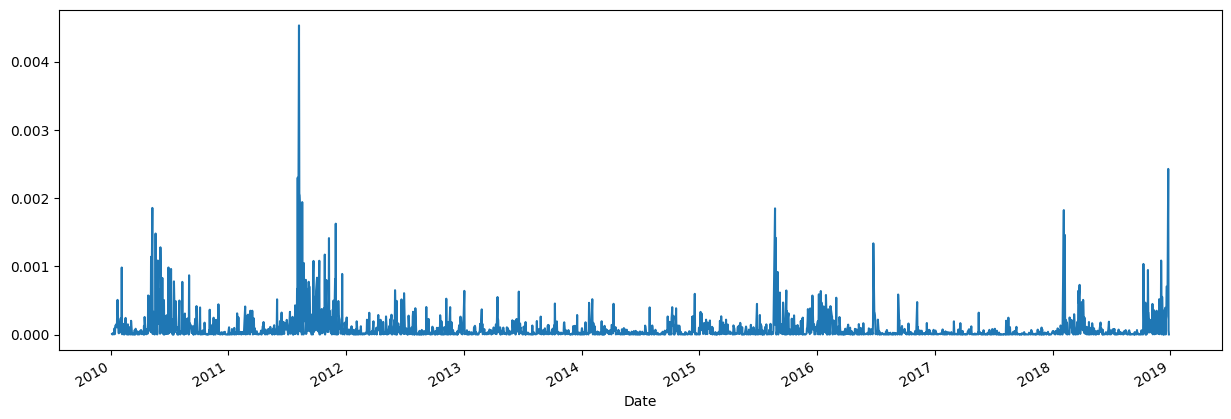

In [10]:
df2['Ysq'].plot(figsize = (15,5));

# **ACF and PACF**

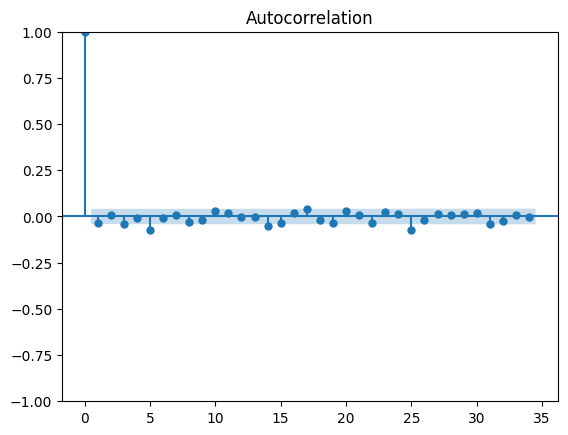

In [11]:
plot_acf(df2['LogRet']);

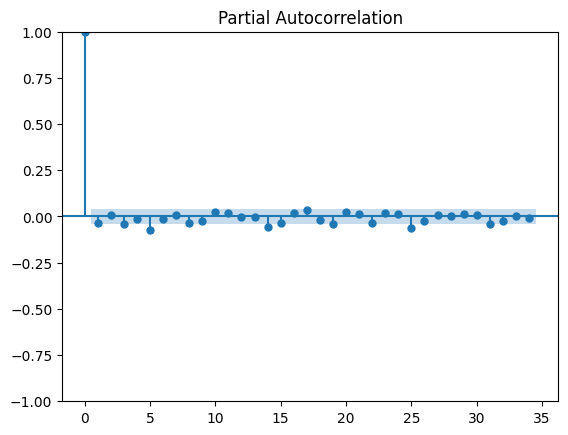

In [12]:
plot_pacf(df2['LogRet']);

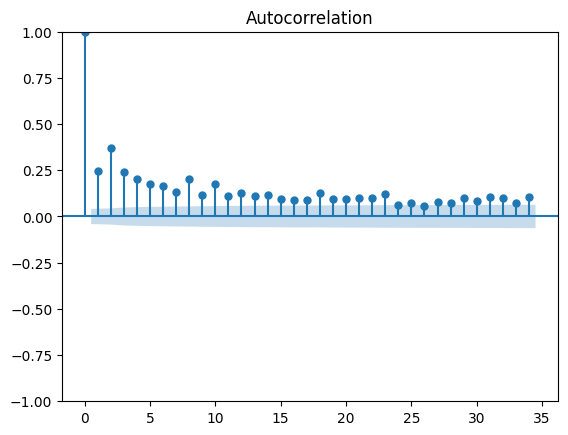

In [13]:
plot_acf(df2['Ysq']);

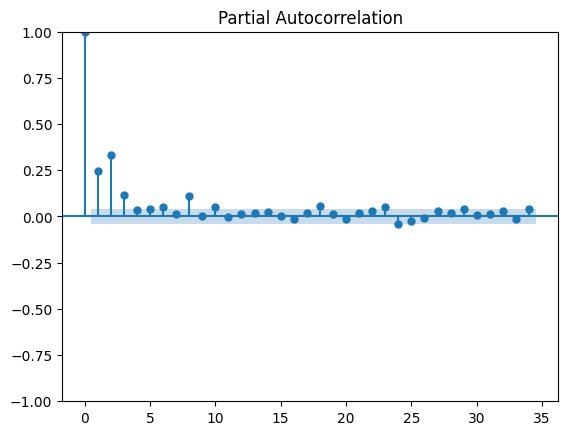

In [14]:
plot_pacf(df2['Ysq']);

# **Train-Test Split**

In [15]:
NTest = 500
train = df2.iloc[:-NTest][['LogRet']].copy()
test = df2.iloc[-NTest:][['LogRet']].copy()

# **GARCH**

In [16]:
model = arch_model(train['LogRet'],vol = 'GARCH',p = 1,q = 1)

In [17]:
#It gives warnning because the scales are to small
#The parameter estimation works better when this value is between 1 and 1000
#Thus, we need to scale our time series
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2668736234320.3926
Iteration:      2,   Func. Count:     19,   Neg. LLF: 681495796603480.9
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2099329788588.272
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1148800069593708.8
Iteration:      5,   Func. Count:     62,   Neg. LLF: 20672973870.71515
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.0138966357037168e+16
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1121326932594.181
Iteration:      8,   Func. Count:    103,   Neg. LLF: 207123748884025.1
Iteration:      9,   Func. Count:    118,   Neg. LLF: 14017524989.133617
Iteration:     10,   Func. Count:    131,   Neg. LLF: 275892953358924.4
Iteration:     11,   Func. Count:    145,   Neg. LLF: -5876.685308750586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5876.68531086581
            Iterations: 15
            Function evaluations: 145
            Gradient evalu

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.532e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [18]:
#Scaling
m = train['LogRet'].mean()
s = test['LogRet'].std()
train['scaled'] = (train['LogRet'] - m)/s
test['scaled'] = (test['LogRet'] - m)/s
df2['scaled'] = (df2['LogRet'] - m)/s

In [19]:
arch1 = arch_model(train['scaled'],vol = 'ARCH',p=1)

In [20]:
res_arch1 = arch1.fit(update_freq = 10)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2758.9937048800584
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7


In [21]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2758.99
Distribution:                  Normal   AIC:                           5523.99
Method:            Maximum Likelihood   BIC:                           5540.41
                                        No. Observations:                 1762
Date:                Sat, Nov 25 2023   Df Residuals:                     1761
Time:                        04:12:42   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0150  2.759e-02      0.545      0.586 [-3.904e-02,6.910e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.1523  9.460e-02     12.181  3.936e-34   [  0.967,  1.338]
alpha[1]       0.1771  4.774e-02      3.709  2.079e-04 [8.350e-02,  0.271]
==========================================================================

Covariance estimator: robust
"""

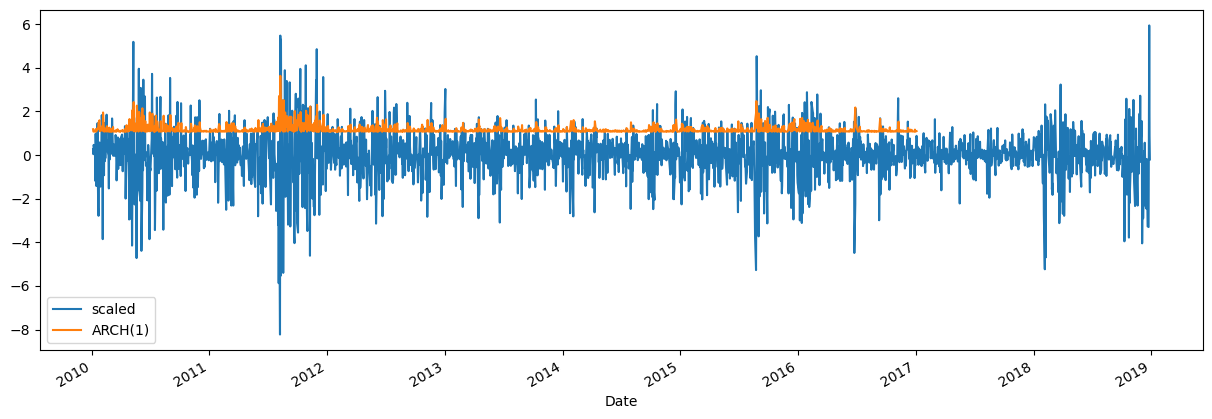

In [22]:
df2['ARCH(1)'] = res_arch1.conditional_volatility
df2[['scaled','ARCH(1)']].plot(figsize = (15,5));

In [23]:
res_arch1.forecast(horizon = NTest)

In [24]:
fcast_arch1 = res_arch1.forecast(horizon=NTest,reindex = True)

In [25]:
fcast_arch1

In [26]:
fcast_arch1.mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
fcast_arch1.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
fcast_arch1.residual_variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
fcast_arch1 = res_arch1.forecast(horizon = NTest,reindex = False)

In [30]:
fcast_arch1.mean

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,...,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031,0.015031


In [31]:
fcast_arch1.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.284314,1.379741,1.396637,1.399629,1.400159,1.400253,1.400269,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273


In [32]:
fcast_arch1.residual_variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.284314,1.379741,1.396637,1.399629,1.400159,1.400253,1.400269,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273


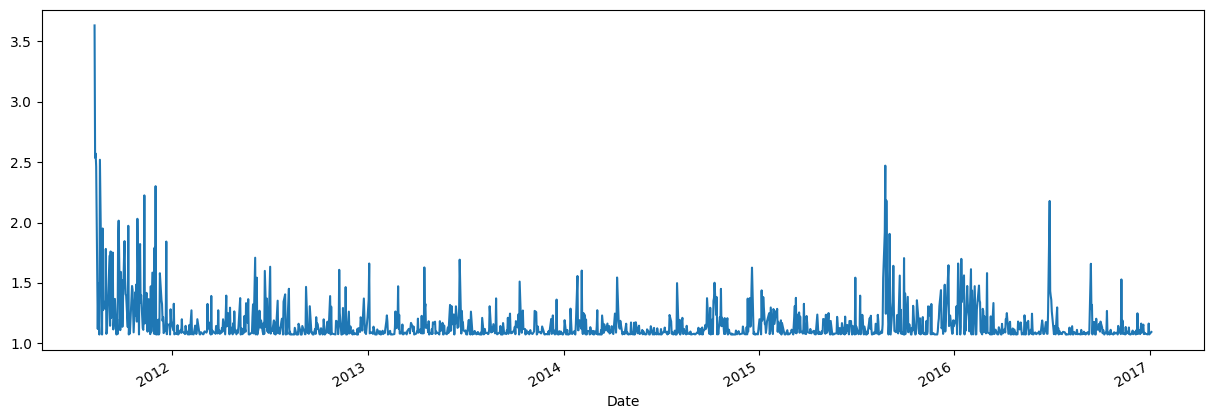

In [33]:
df2.loc['2011-08-09':]['ARCH(1)'].plot(figsize = (15,5));

In [34]:
fcast_arch1 = res_arch1.forecast(
    horizon = NTest,reindex = True,start = '2011-08-01'
)

In [35]:
fcast_arch1.variance['2011-07-28':'2011-08-05']

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
Date,,,,,,,,,,,,,,,,,,,,,
2011-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.211915,1.366921,1.394367,1.399227,1.400088,1.400240,1.400267,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-02,2.972328,1.678627,1.449559,1.409000,1.401818,1.400546,1.400321,1.400281,1.400274,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-03,1.214825,1.367437,1.394459,1.399243,1.400090,1.400240,1.400267,1.400272,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-04,7.294964,2.444009,1.585081,1.432996,1.406067,1.401299,1.400454,1.400305,1.400278,1.400274,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273
2011-08-05,1.162906,1.358244,1.392831,1.398955,1.400039,1.400231,1.400265,1.400271,1.400273,1.400273,...,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273,1.400273


In [36]:
fcast_arch1.variance.loc['2011-08-09'].to_numpy().shape

(500,)

In [37]:
#Get the index of that date
df.index.get_loc('2011-08-09')

403

In [38]:
#Get date after 500 days
df.index[402 + 500]

Timestamp('2013-08-05 00:00:00')

In [39]:
df2.loc['2011-08-10':'2013-08-06','ARCH(1) Forecast'] = np.sqrt(
    fcast_arch1.variance.loc['2011-08-09'].to_numpy()
)

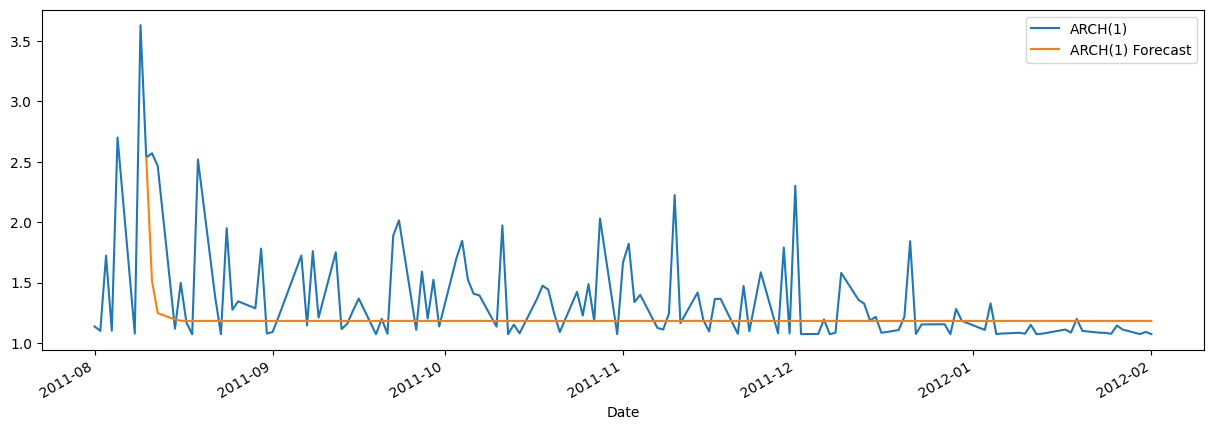

In [40]:
df2.loc['2011-08-01':'2012-02-01'][['ARCH(1)','ARCH(1) Forecast']].plot(figsize = (15,5));

In [41]:
fcast_arch1.variance.index.get_loc('2011-08-17')

408

In [42]:
df2.index[408 + 500]

Timestamp('2013-08-14 00:00:00')

In [43]:
df2.loc['2011-08-18':'2013-08-14','ARCH(1) Forecast Low'] = np.sqrt(
    fcast_arch1.variance.loc['2011-08-17'].to_numpy()
)

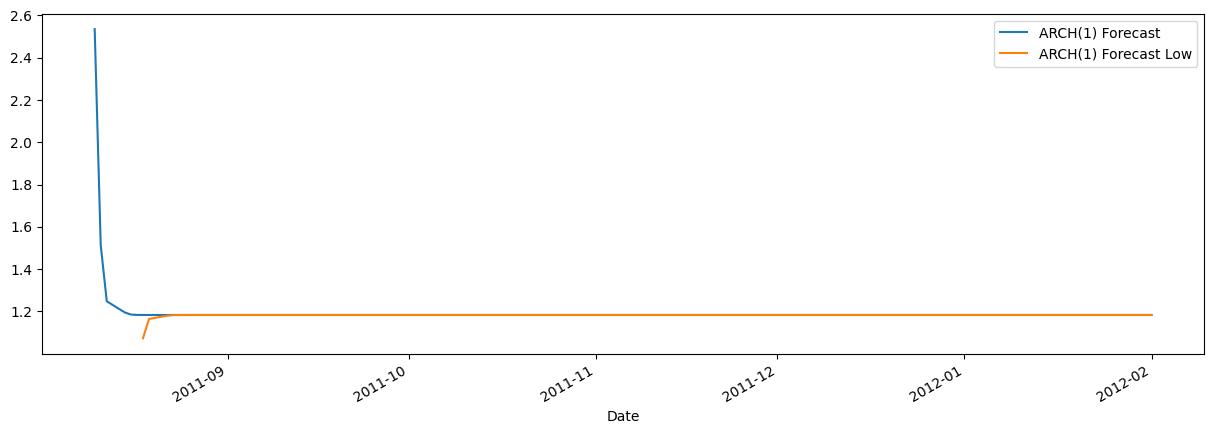

In [44]:
#Valality test
cols = [
    'ARCH(1) Forecast','ARCH(1) Forecast Low'
]
df2.loc['2011-08-01':'2012-02-01'][cols].plot(figsize = (15,5));

In [45]:
#Theoretical unconditional variance
res_arch1.params

mu          0.015031
omega       1.152335
alpha[1]    0.177064
Name: params, dtype: float64

In [46]:
res_arch1.params['omega'] / (1 - res_arch1.params['alpha[1]'])

1.4002727344070522

In [47]:
fcast_arch1.variance.loc['2011-08-17'].to_numpy()[-1]

1.4002727344070522

In [48]:
fcast_arch1.variance.loc['2011-08-09'].to_numpy()[-1]

1.4002727344070522

# **GARCH(1,1)**

In [49]:
garch11 = arch_model(train['scaled'],vol = 'GARCH',p = 1,q = 1)

In [50]:
res_garch11 = garch11.fit(update_freq = 10)

Iteration:     10,   Func. Count:     62,   Neg. LLF: 2570.1176218396467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2570.1176176707686
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12


In [51]:
res_garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2570.12
Distribution:                  Normal   AIC:                           5148.24
Method:            Maximum Likelihood   BIC:                           5170.13
                                        No. Observations:                 1762
Date:                Sat, Nov 25 2023   Df Residuals:                     1761
Time:                        04:12:51   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0340  2.213e-02      1.538      0.124 [-9.336e-03,7.740e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0660  1.492e-02      4.427  9.560e-06 [3.680e-02,9.528e-02]
alpha[1]       0.1499  2.499e-02      6.000  1.971e-09     [  0.101,  0.199]
beta[1]        0.8021  2.545e-02     31.515 5.444e-218     [  0.752,  0.852]
============================================================================

Covariance estimator: robust
"""

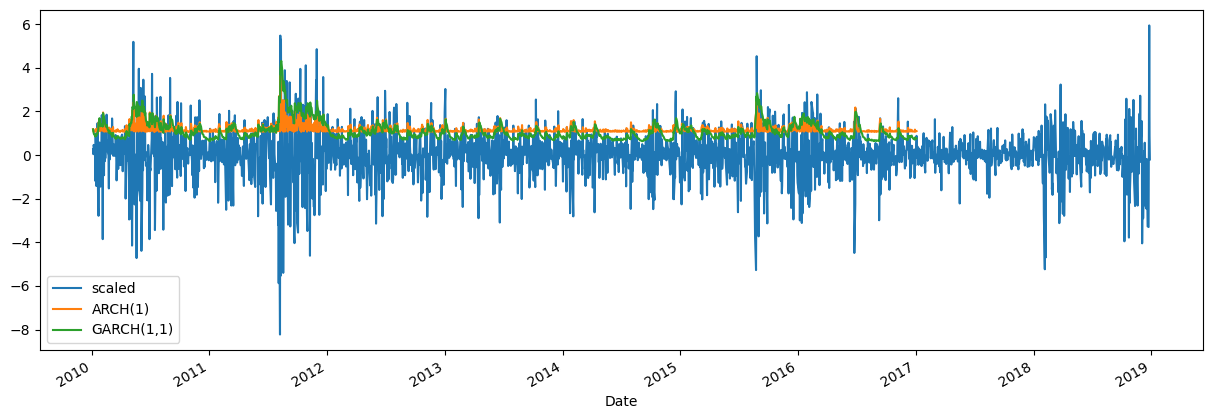

In [52]:
df2['GARCH(1,1)'] = res_garch11.conditional_volatility
df2[['scaled','ARCH(1)','GARCH(1,1)']].plot(figsize = (15,5));

In [54]:
fcast_garch11 = res_garch11.forecast(
    horizon = NTest,reindex = False,start = '2011-08-09'
)

In [55]:
df2.loc['2011-08-10':'2013-08-06','GARCH(1,1) Forecast'] = np.sqrt(
    fcast_garch11.residual_variance.loc['2011-08-09'].to_numpy()
)

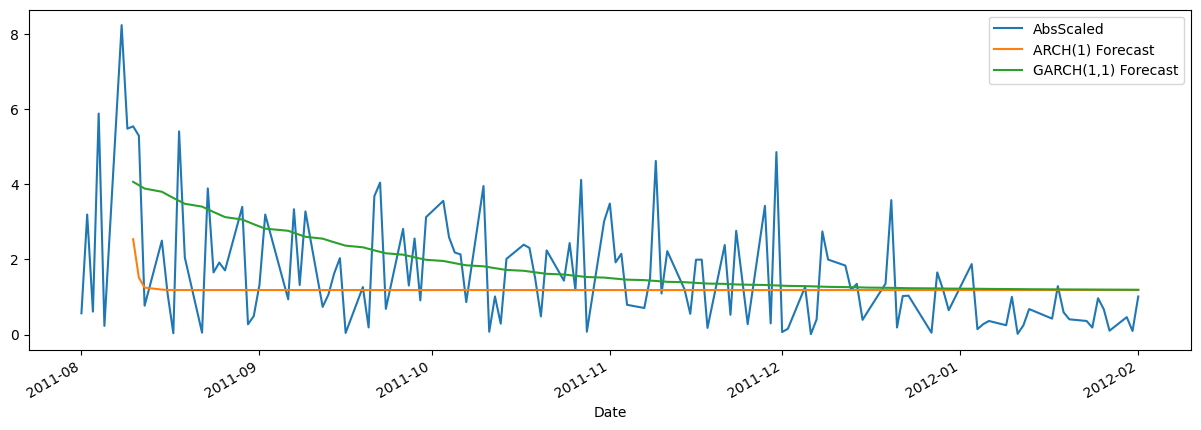

In [59]:
df2['AbsScaled'] = df2['scaled'].abs()

cols = [
    'AbsScaled',
    'ARCH(1) Forecast',
    'GARCH(1,1) Forecast'
]
df2.loc['2011-08-01':'2012-02-01'][cols].plot(figsize = (15,5));

# **T-Distribution**

In [62]:
garchlit = arch_model(train['scaled'],vol = 'GARCH', p = 1,q = 1,dist = 'StudentsT')

In [63]:
res_garchlit = garchlit.fit(update_freq=10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2531.192054224512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2531.189462796183
            Iterations: 14
            Function evaluations: 97
            Gradient evaluations: 14


In [64]:
res_garchlit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2531.19
Distribution:      Standardized Student's t   AIC:                           5072.38
Method:                  Maximum Likelihood   BIC:                           5099.75
                                              No. Observations:                 1762
Date:                      Sat, Nov 25 2023   Df Residuals:                     1761
Time:                              04:33:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0559  2.006e-02      2.788  5.310e-03 [1.660e-02,9.523e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0562  1.308e-02      4.296  1.743e-05 [3.056e-02,8.184e-02]
alpha[1]       0.1615  2.507e-02      6.442  1.177e-10     [  0.112,  0.211]
beta[1]        0.8081  2.353e-02     34.347 1.537e-258     [  0.762,  0.854]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.5805      0.733      7.610  2.741e-14 [  4.143,  7.018]
========================================================================

Covariance estimator: robust
"""

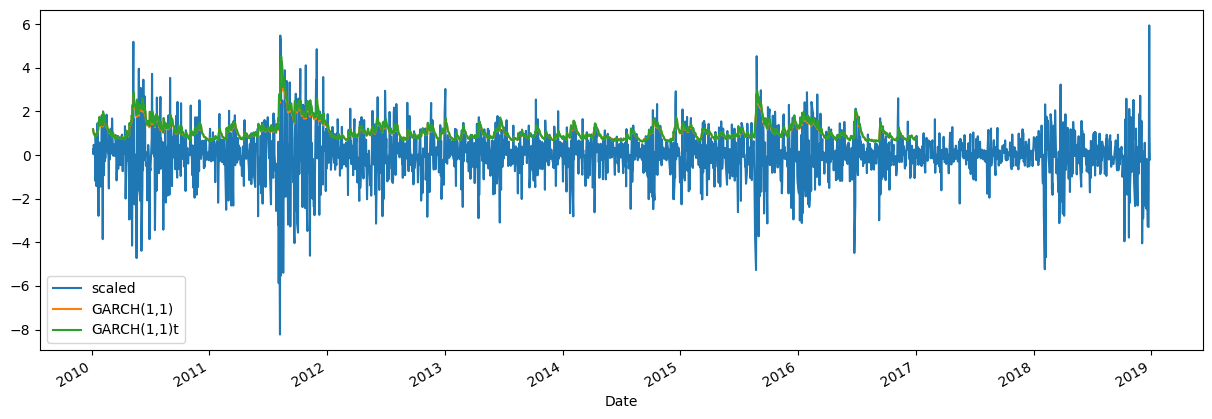

In [67]:
df2['GARCH(1,1)t'] = res_garchlit.conditional_volatility
cols = [
    'scaled',
    'GARCH(1,1)',
    'GARCH(1,1)t'
]
df2[cols].plot(figsize = (15,5));

In [68]:
fcast_garchlit = res_garchlit.forecast(
    horizon = NTest,reindex = False,start = '2011-08-09'
)

In [72]:
df2.loc['2011-08-10':'2013-08-06','GARCH(1,1)t Forecast'] = np.sqrt(fcast_garchlit.residual_variance.loc['2011-08-09'].to_numpy())

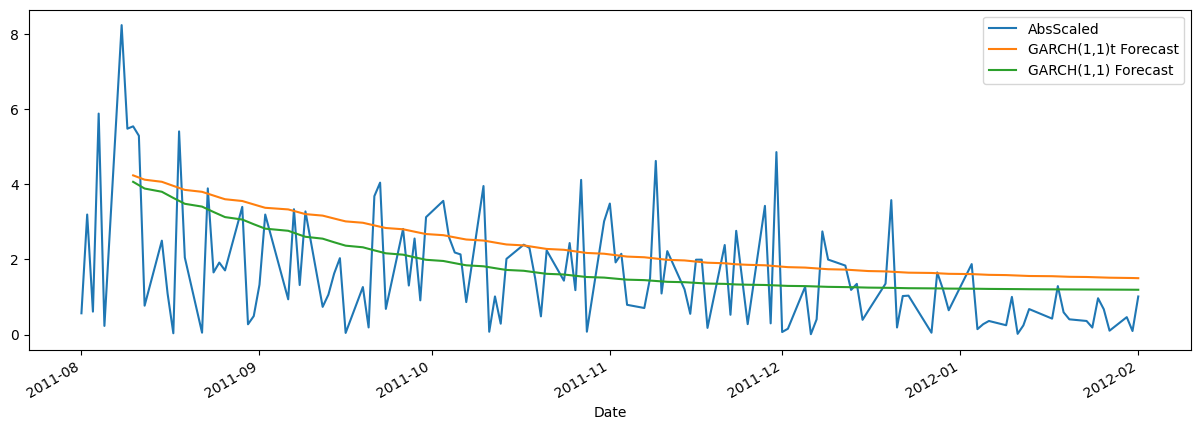

In [73]:
cols = [
    'AbsScaled',
    'GARCH(1,1)t Forecast',
    'GARCH(1,1) Forecast'
]
df2.loc['2011-08-01':'2012-02-01'][cols].plot(figsize = (15,5));

# **GARCH(p,q)**

In [74]:
garchpq = arch_model(train['scaled'],p = 8,q = 5,dist = 'StudentsT')

In [75]:
res_garchpq = garchpq.fit(update_freq = 10)

Iteration:     10,   Func. Count:    185,   Neg. LLF: 2678.256488785693
Iteration:     20,   Func. Count:    368,   Neg. LLF: 2525.536750741003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2525.288224444763
            Iterations: 29
            Function evaluations: 520
            Gradient evaluations: 29


In [76]:
res_garchpq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       scaled   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2525.29
Distribution:      Standardized Student's t   AIC:                           5082.58
Method:                  Maximum Likelihood   BIC:                           5170.16
                                              No. Observations:                 1762
Date:                      Sat, Nov 25 2023   Df Residuals:                     1761
Time:                              04:53:45   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0579  2.018e-02      2.869  4.119e-03 [1.834e-02,9.744e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1896      0.126      1.510      0.131 [-5.657e-02,  0.436]
alpha[1]       0.0751  3.299e-02      2.278  2.273e-02  [1.049e-02,  0.140]
alpha[2]       0.2069  8.144e-02      2.541  1.106e-02  [4.731e-02,  0.367]
alpha[3]       0.0828      0.196      0.423      0.672    [ -0.301,  0.466]
alpha[4]   9.7387e-12      0.110  8.868e-11      1.000    [ -0.215,  0.215]
alpha[5]       0.0328      0.147      0.223      0.824    [ -0.256,  0.321]
alpha[6]       0.0383  6.546e-02      0.585      0.559 [-9.002e-02,  0.167]
alpha[7]       0.0259  8.822e-02      0.293      0.769    [ -0.147,  0.199]
alpha[8]       0.0361  4.226e-02      0.853      0.394 [-4.678e-02,  0.119]
beta[1]    1.9218e-11      0.902  2.130e-11      1.000    [ -1.768,  1.768]
beta[2]        0.3957      0.451      0.877      0.380    [ -0.488,  1.280]
beta[3]    2.3953e-12      0.842  2.846e-12      1.000    [ -1.650,  1.650]
beta[4]    2.3244e-11      0.437  5.317e-11      1.000    [ -0.857,  0.857]
beta[5]    3.5359e-12      0.523  6.757e-12      1.000    [ -1.026,  1.026]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.7060      0.771      7.398  1.384e-13 [  4.194,  7.218]
========================================================================

Covariance estimator: robust
"""

In [77]:
res_arch1.aic,res_garch11.aic,res_garchlit.aic,res_garchpq.aic

(5523.987409760117, 5148.235235341537, 5072.378925592366, 5082.576448889526)

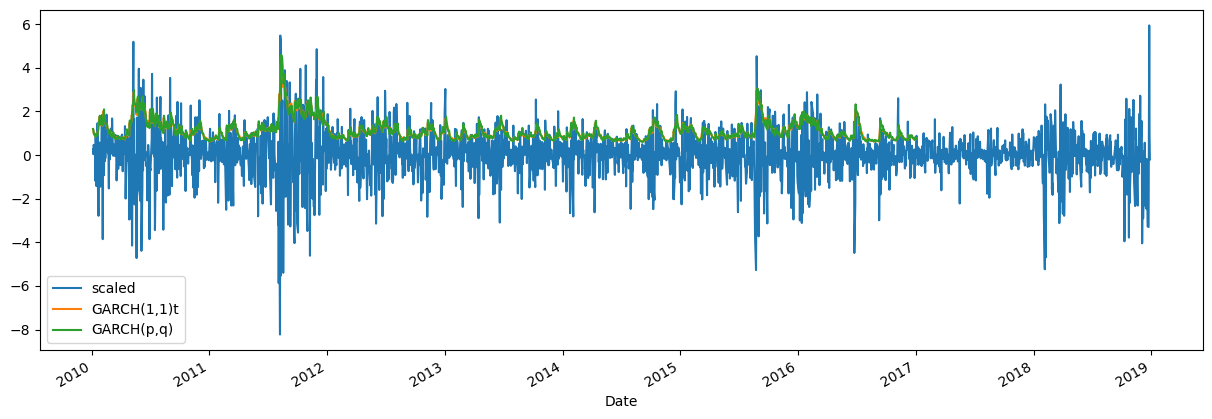

In [78]:
df2['GARCH(p,q)'] = res_garchpq.conditional_volatility

cols = [
    'scaled',
    'GARCH(1,1)t',
    'GARCH(p,q)'
]

df2[cols].plot(figsize = (15,5));

In [79]:
fcast_garchpq = res_garchpq.forecast(
    horizon = NTest,reindex = False,start = '2011-08-09'
)

In [80]:
df2.loc['2011-08-10':'2013-08-06','GARCH(p,q) Forecast'] = np.sqrt(
    fcast_garchlit.variance.loc['2011-08-09'].to_numpy()
)

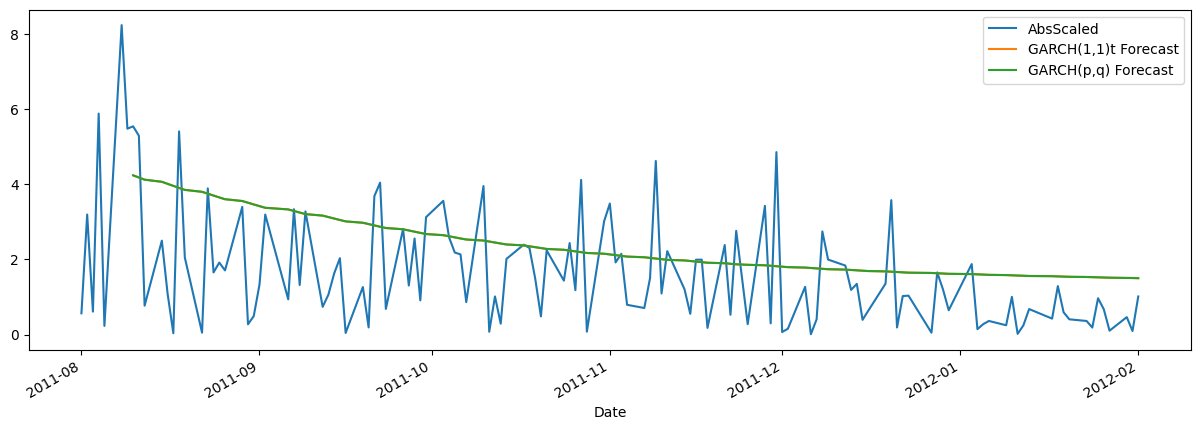

In [82]:
#No difference between GARCH(1,1) and GARCH(p,q)
cols = [
    'AbsScaled',
    'GARCH(1,1)t Forecast',
    'GARCH(p,q) Forecast'
]

df2.loc['2011-08-01':'2012-02-01'][cols].plot(figsize = (15,5));

In [89]:
train_idx = df2.index <= train.index[-1]
test_idx = ~train_idx

In [90]:
df2.loc[train_idx,'GARCH(p,q) train'] = res_garchpq.conditional_volatility
df2.loc[test_idx,'GARCH(p,q) test'] = np.sqrt(
    fcast_garchpq.variance.iloc[-1].to_numpy()
)

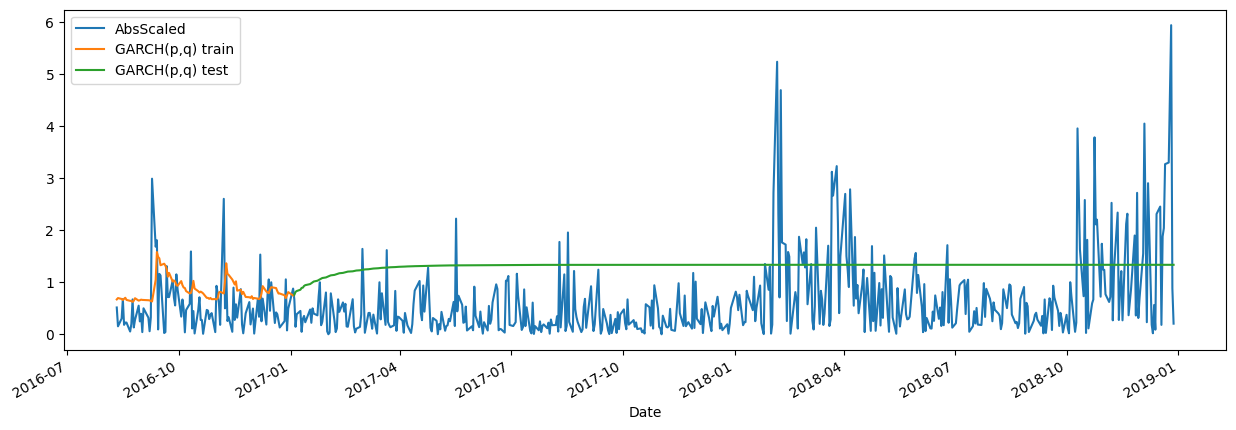

In [94]:
#+100 is to show the train set
#It is impossible to preidct the volatility fluctuation for several years ahead
cols = [
  'AbsScaled',
  'GARCH(p,q) train',
  'GARCH(p,q) test'
]
df2.iloc[-(NTest+100):][cols].plot(figsize = (15,5));